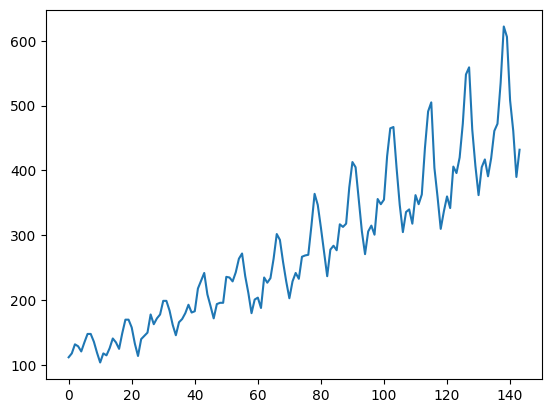

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [ ]:
# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_normalized = scaler.fit_transform(train)
test_normalized = scaler.transform(test)

In [ ]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([114, 1, 1]) torch.Size([114, 1, 1])
torch.Size([28, 1, 1]) torch.Size([28, 1, 1])


/tmp/ipython-input-707328685.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(X), torch.tensor(y)


In [ ]:

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(100, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(100, 1)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [ ]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

n_epochs = 5000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

/tmp/ipython-input-1640660370.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipython-input-1640660370.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 257.4908, test RMSE 444.9407
Epoch 100: train RMSE 226.3715, test RMSE 411.9462
Epoch 200: train RMSE 201.5064, test RMSE 385.0344
Epoch 300: train RMSE 179.6013, test RMSE 360.6848
Epoch 400: train RMSE 159.5917, test RMSE 337.6055
Epoch 500: train RMSE 142.2699, test RMSE 316.5587
Epoch 600: train RMSE 127.5919, test RMSE 297.3792
Epoch 700: train RMSE 114.8075, test RMSE 279.6574
Epoch 800: train RMSE 102.5830, test RMSE 262.4209
Epoch 900: train RMSE 91.7350, test RMSE 246.0359
Epoch 1000: train RMSE 82.0296, test RMSE 230.4233
Epoch 1100: train RMSE 73.4403, test RMSE 215.7016
Epoch 1200: train RMSE 65.9758, test RMSE 201.8969
Epoch 1300: train RMSE 59.3085, test RMSE 188.8673
Epoch 1400: train RMSE 53.6331, test RMSE 176.5574
Epoch 1500: train RMSE 48.7703, test RMSE 165.1696
Epoch 1600: train RMSE 44.2577, test RMSE 154.4346
Epoch 1700: train RMSE 40.7272, test RMSE 144.6600
Epoch 1800: train RMSE 37.7795, test RMSE 135.7621
Epoch 1900: train RMSE 35.4685, te

In [ ]:

model_gru = GRUModel()
optimizer = optim.Adam(model_gru.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

n_epochs = 5000
for epoch in range(n_epochs):
    model_gru.train()
    for X_batch, y_batch in loader:
        y_pred = model_gru(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model_gru.eval()
    with torch.no_grad():
        y_pred = model_gru(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model_gru(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

/tmp/ipython-input-1460317665.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipython-input-1460317665.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 257.0013, test RMSE 444.3847
Epoch 100: train RMSE 217.5014, test RMSE 402.4120
Epoch 200: train RMSE 185.4781, test RMSE 367.2918
Epoch 300: train RMSE 158.6245, test RMSE 336.4609
Epoch 400: train RMSE 136.5114, test RMSE 309.2256
Epoch 500: train RMSE 119.0241, test RMSE 285.3737
Epoch 600: train RMSE 103.4647, test RMSE 263.4861
Epoch 700: train RMSE 89.9052, test RMSE 242.9827
Epoch 800: train RMSE 78.4912, test RMSE 224.0741
Epoch 900: train RMSE 68.6714, test RMSE 206.7132
Epoch 1000: train RMSE 60.4105, test RMSE 190.7714
Epoch 1100: train RMSE 53.4348, test RMSE 176.1538
Epoch 1200: train RMSE 47.7144, test RMSE 162.8932
Epoch 1300: train RMSE 43.1632, test RMSE 150.9436
Epoch 1400: train RMSE 39.6691, test RMSE 140.5857
Epoch 1500: train RMSE 36.5634, test RMSE 130.6512
Epoch 1600: train RMSE 34.2915, test RMSE 121.9876
Epoch 1700: train RMSE 32.3733, test RMSE 114.6102
Epoch 1800: train RMSE 31.0045, test RMSE 108.0071
Epoch 1900: train RMSE 30.2977, test

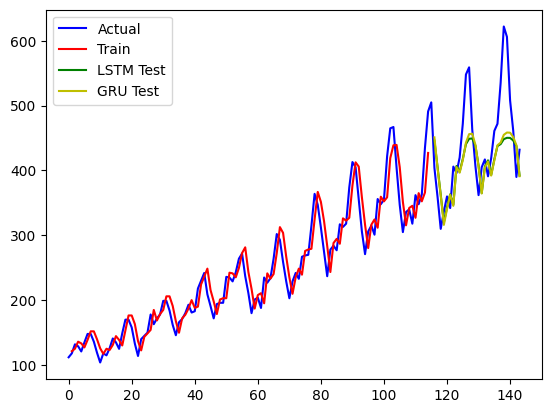

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred_gru = model_gru(X_train)
    y_pred = y_pred[:, -1, :]
    y_pred_gru = y_pred_gru[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :].numpy()
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :].numpy()
    test_plot_gru = np.ones_like(timeseries) * np.nan
    test_plot_gru[train_size+lookback:len(timeseries)] = model_gru(X_test)[:, -1, :].numpy()



# plot
plt.plot(timeseries, c='b', label='Actual')
plt.plot(train_plot, c='r', label='Train')
plt.plot(test_plot, c='g', label='LSTM Test')
plt.plot(test_plot_gru, c='y', label='GRU Test')
plt.legend()
plt.show()